# How do package dependency network grow over time?

In this notebook we plan to investigate the dependencies in the Pypi dataset and try to look at
how they change over time.

## Loading data and importing libraries

In [1]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

In [2]:
# data_folder = '../data/'
data_folder = 'https://zenodo.org/record/2620607/files/'

df_dep = pd.read_csv(data_folder + 'pypi_dependencies.csv', error_bad_lines=False, warn_bad_lines=False)
df_proj = pd.read_csv(data_folder + 'pypi_projects.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
df_repo = pd.read_csv(data_folder + 'pypi_projects_with_repository_fields.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
df_ver = pd.read_csv(data_folder + 'pypi_versions.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)

for df in [df_dep, df_proj, df_repo, df_ver]:
    time_fields = []
    for col in df.columns:
        if 'timestamp' in col:
            time_fields.append(col)
    for time_field in time_fields:
        try:
            df[time_field] = df[time_field].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        except:
            pass
        
del df

## Defining helper functions and defaults

In [3]:
# Helper Functions
def add_three_months(t):
    for i in range(3):
        t = add_a_month(t)
    return t
def add_a_month(t):
    return (t.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)
def print_time(t):
    return t.strftime("%Y-%m-%dT%H:%M:%S")

!mkdir figs
figs_dir = 'figs/'

mkdir: cannot create directory ‘figs’: File exists


In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

## Project Publishing over time

In [5]:
first_time = df_ver['published_timestamp'].min()
last_time = df_ver['published_timestamp'].max()
print('soonest start time:', first_time)
print('latest start time:', last_time)

soonest start time: 2005-03-21 15:59:25
latest start time: 2018-12-22 21:15:25


In [6]:
# Add the published timestamp from the version table
df_proj_pub = df_ver.groupby(['project_id'])['published_timestamp'].min()
proj_pubs = df_proj['id'].apply(lambda x: df_proj_pub[x] if x in df_proj_pub.index else np.nan)
proj_pubs[proj_pubs.isnull()] = first_time
df_proj['published_timestamp'] = proj_pubs

In [7]:
project_counts = {}
project_counts['StartDate'] = []
project_counts['EndDate'] = []
project_counts['count'] = []
project_counts['count_total'] = []

start_time = add_a_month(first_time)
end_time = add_a_month(start_time)
while end_time < last_time.replace(day=1):
    project_counts['StartDate'].append(start_time)
    project_counts['EndDate'].append(end_time)
    
    # Published projects
    idxs = (df_proj['published_timestamp'] > start_time) & (df_proj['published_timestamp'] < end_time)
    project_counts['count'].append(sum(idxs))
    
    # Total Projects
    idxs = (df_proj['published_timestamp'] < end_time)
    project_counts['count_total'].append(sum(idxs))
    
    # Total Projects
    
    start_time = end_time
    end_time = add_a_month(start_time)

/home/ubuntu/anaconda3/envs/mlse/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


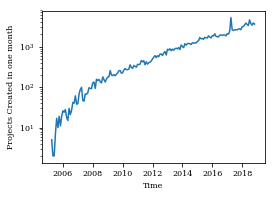

In [8]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(4,2.8))

# plt.figure(figsize=(7,7))
# plt.subplot(211)
plt.semilogy(project_counts['StartDate'], project_counts['count'], '-')
plt.xlabel('Time')
plt.ylabel('Projects Created in one month')

# plt.subplot(212)
# plt.semilogy(project_counts['EndDate'], project_counts['count_total'], '-')
# plt.xlabel('Time')
# plt.ylabel('Total Created Projects')

plt.savefig(figs_dir+'project-publish-over-time.pdf')
plt.savefig(figs_dir+'project-publish-over-time.png', dpi=300)

set_plt_rc()

In [9]:
print(project_counts['count'])

[5, 2, 2, 7, 17, 10, 19, 11, 19, 26, 24, 28, 18, 15, 30, 21, 27, 42, 40, 61, 38, 39, 69, 87, 99, 47, 45, 68, 67, 73, 97, 93, 92, 129, 133, 93, 157, 145, 155, 136, 127, 179, 153, 134, 159, 177, 182, 257, 200, 193, 203, 191, 207, 227, 253, 258, 220, 228, 267, 289, 271, 270, 280, 356, 306, 291, 342, 325, 311, 366, 361, 368, 456, 423, 450, 357, 424, 370, 401, 418, 444, 498, 548, 601, 538, 598, 566, 653, 660, 605, 699, 759, 622, 863, 829, 886, 794, 871, 816, 889, 916, 886, 954, 846, 1101, 1005, 948, 1186, 1091, 1183, 1205, 1183, 1128, 1249, 1219, 1242, 1234, 1343, 1412, 1684, 1564, 1592, 1523, 1711, 1651, 1637, 1852, 1720, 1641, 1866, 1847, 2083, 1798, 1762, 1741, 1937, 1934, 1908, 1959, 1942, 1853, 2089, 2042, 2388, 5258, 2628, 2503, 2624, 2607, 2611, 2728, 2773, 2633, 3090, 3165, 3453, 3821, 3567, 3327, 4595, 3710, 3407, 3854, 3617]


## Versions over time

In [10]:
first_time = df_ver['published_timestamp'].min()
last_time = df_ver['published_timestamp'].max()
print('soonest start time:', first_time)
print('latest start time:', last_time)

soonest start time: 2005-03-21 15:59:25
latest start time: 2018-12-22 21:15:25


In [11]:
dep_counts = {}
dep_counts['StartDate'] = []
dep_counts['EndDate'] = []
dep_counts['count'] = []
dep_counts['count_total'] = []

start_time = add_a_month(first_time)
end_time = add_a_month(start_time)
while end_time < last_time.replace(day=1):
    dep_counts['StartDate'].append(start_time)
    dep_counts['EndDate'].append(end_time)
    
    # Published versions (updates)
    idxs = (df_ver['published_timestamp'] > start_time) & (df_ver['published_timestamp'] < end_time)
    dep_counts['count'].append(sum(idxs))
    
    # Published version (total)
    idxs = (df_ver['published_timestamp'] < end_time)
    dep_counts['count_total'].append(sum(idxs))
    
    # Total Projects
    
    start_time = end_time
    end_time = add_a_month(start_time)

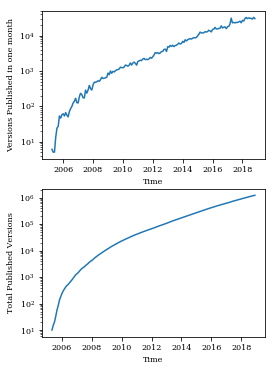

In [12]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)

plt.figure(figsize=(4,6))
# plt.figure(figsize=(7,7))
plt.subplot(211)
# plt.plot(dep_counts['StartDate'], dep_counts['count'], '-')
plt.semilogy(dep_counts['StartDate'], dep_counts['count'], '-')
plt.xlabel('Time')
plt.ylabel('Versions Published in one month')

plt.subplot(212)
# plt.plot(dep_counts['EndDate'], dep_counts['count_total'], '-')
plt.semilogy(dep_counts['EndDate'], dep_counts['count_total'], '-')
plt.xlabel('Time')
plt.ylabel('Total Published Versions')

plt.savefig(figs_dir+'versions-over-time.pdf')
plt.savefig(figs_dir+'versions-over-time.png', dpi=300)

set_plt_rc()

In [13]:
print(dep_counts['count'])

[6, 5, 5, 13, 24, 27, 53, 46, 58, 61, 53, 66, 56, 50, 71, 85, 99, 124, 139, 168, 126, 124, 189, 232, 213, 174, 171, 286, 235, 287, 389, 313, 287, 406, 479, 476, 492, 525, 510, 565, 658, 609, 622, 638, 664, 869, 783, 992, 859, 972, 936, 1008, 1072, 1094, 1139, 1281, 1235, 1230, 1295, 1459, 1429, 1360, 1445, 1679, 1464, 1683, 1773, 1642, 1457, 1845, 1935, 2007, 1956, 2178, 2261, 2084, 2144, 2083, 2197, 2412, 2291, 2517, 2855, 3295, 3167, 3291, 3081, 3244, 3531, 3586, 4067, 4131, 3563, 4866, 4731, 5268, 4955, 5332, 4880, 5226, 5362, 5692, 6152, 5772, 5979, 6884, 6414, 7611, 7074, 7608, 7950, 8249, 7961, 8378, 8827, 8581, 8877, 9873, 10869, 12541, 11934, 11857, 12052, 12906, 12642, 12971, 14193, 13529, 12733, 14938, 15217, 17092, 15444, 15437, 15929, 16097, 18861, 16482, 17221, 17591, 15768, 17867, 18318, 20973, 31197, 23064, 23574, 22912, 23703, 23449, 24361, 25517, 23099, 26973, 25922, 29953, 32709, 30274, 31641, 30990, 30752, 29418, 32815, 30333]


## Dependencies over time

In [14]:
first_time = df_ver['published_timestamp'].min()
last_time = df_ver['published_timestamp'].max()
print('soonest start time:', first_time)
print('latest start time:', last_time)

soonest start time: 2005-03-21 15:59:25
latest start time: 2018-12-22 21:15:25


In [15]:
dep_counts = {}
dep_counts['StartDate'] = []
dep_counts['EndDate'] = []
dep_counts['count'] = []
dep_counts['count_dep'] = []
dep_counts['dep_per_ver'] = []
dep_counts['count_total'] = []
dep_counts['count_dep_total'] = []
dep_counts['dep_per_ver_total'] = []

start_time = add_a_month(first_time)
end_time = add_a_month(start_time)
while end_time < last_time.replace(day=1):
    dep_counts['StartDate'].append(start_time)
    dep_counts['EndDate'].append(end_time)

    # Published versions (updates)
    idxs = (df_ver['published_timestamp'] > start_time) & (df_ver['published_timestamp'] < end_time)
    vers = df_ver[idxs]
    dep_counts['count'].append(sum(idxs))

    # Dependencies count
    df = pd.merge(df_dep, vers, how='inner', left_on='version_id', right_on='id')
    dep_counts['count_dep'].append(df.shape[0])
    
    # Dependecies per version
    dep_counts['dep_per_ver'].append(df.shape[0] / max(df['version_id'].nunique(), 1))

    # Published version (total)
    idxs = (df_ver['published_timestamp'] > first_time) & (df_ver['published_timestamp'] < end_time)
    vers = df_ver[idxs]
    dep_counts['count_total'].append(sum(idxs))

    # Dependencies count
    df = pd.merge(df_dep, vers, how='inner', left_on='version_id', right_on='id')
    dep_counts['count_dep_total'].append(df.shape[0])
    
    # Dependecies per version (total)
    dep_counts['dep_per_ver_total'].append(df.shape[0] / max(df['version_id'].nunique(),1))

    start_time = end_time
    end_time = add_a_month(start_time)

### Dependency Count

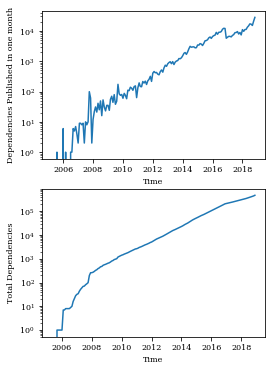

In [16]:
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)

plt.figure(figsize=(4,6))
# plt.figure(figsize=(7,7))
plt.subplot(211)
# plt.plot(dep_counts['StartDate'], dep_counts['count_dep'], '-')
plt.semilogy(dep_counts['StartDate'], dep_counts['count_dep'], '-')
plt.xlabel('Time')
plt.ylabel('Dependencies Published in one month')

plt.subplot(212)
# plt.plot(dep_counts['EndDate'], dep_counts['count_dep_total'], '-')
plt.semilogy(dep_counts['EndDate'], dep_counts['count_dep_total'], '-')
plt.xlabel('Time')
plt.ylabel('Total Dependencies')

plt.savefig(figs_dir+'dependencies-over-time.pdf')
plt.savefig(figs_dir+'dependencies-over-time.png', dpi=300)

set_plt_rc()

In [17]:
print(dep_counts['count_dep'])

[0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 1, 1, 6, 5, 7, 4, 2, 9, 9, 8, 9, 2, 10, 8, 10, 99, 61, 2, 12, 22, 31, 21, 41, 25, 49, 16, 53, 31, 23, 35, 35, 24, 55, 70, 44, 79, 38, 48, 173, 84, 75, 80, 60, 87, 75, 58, 111, 107, 139, 129, 110, 145, 154, 63, 134, 193, 147, 144, 214, 191, 220, 171, 226, 253, 318, 216, 405, 458, 417, 426, 375, 356, 452, 516, 436, 605, 741, 679, 826, 909, 964, 828, 972, 779, 935, 1018, 1050, 1226, 1209, 1304, 1519, 1829, 1936, 1685, 2018, 2572, 3104, 2897, 2968, 2986, 2769, 2793, 3433, 3398, 3815, 3682, 3298, 3881, 4721, 4818, 5117, 5911, 6301, 5683, 6544, 7018, 7235, 8968, 7758, 9040, 9070, 9539, 11385, 12214, 12054, 5724, 6225, 6617, 6609, 6357, 7086, 7564, 8736, 8870, 9521, 7901, 8905, 7380, 11022, 9704, 11087, 11211, 13232, 14733, 17052, 16743, 15129, 20888, 27983]


### Dependency per package count

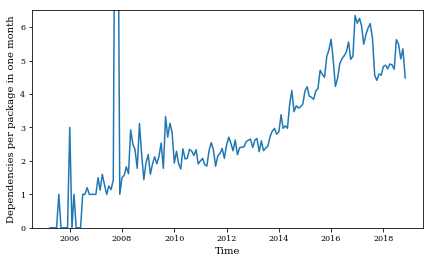

In [18]:
plt.figure(figsize=(7,4))

# plt.figure(figsize=(7,7))
# plt.subplot(211)
plt.plot(dep_counts['StartDate'], dep_counts['dep_per_ver'], '-')
plt.xlabel('Time')
plt.ylabel('Dependencies per package in one month')
plt.ylim(0,6.5)

# plt.subplot(212)
# plt.plot(dep_counts['EndDate'], dep_counts['dep_per_ver_total'], '-')
# plt.xlabel('Time')
# plt.ylabel('Total Dependencies per package')

plt.savefig(figs_dir+'dependency-per-package-over-time.pdf')
plt.savefig(figs_dir+'dependency-per-package-over-time.png', dpi=300)

In [19]:
print(dep_counts['dep_per_ver'])

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 1.5, 1.125, 1.6, 1.2857142857142858, 1.0, 1.25, 1.1428571428571428, 1.4285714285714286, 14.142857142857142, 12.2, 1.0, 1.5, 1.5714285714285714, 1.8235294117647058, 1.6153846153846154, 2.9285714285714284, 2.5, 2.3333333333333335, 1.7777777777777777, 3.1176470588235294, 2.2142857142857144, 1.4375, 1.9444444444444444, 2.1875, 1.6, 1.896551724137931, 2.121212121212121, 1.9130434782608696, 2.135135135135135, 2.533333333333333, 1.7777777777777777, 3.326923076923077, 2.7096774193548385, 3.125, 2.857142857142857, 1.935483870967742, 2.289473684210526, 1.9230769230769231, 1.7575757575757576, 2.3617021276595747, 2.0576923076923075, 2.074626865671642, 2.3454545454545452, 2.2916666666666665, 2.1641791044776117, 2.3333333333333335, 1.9090909090909092, 2.0, 2.075268817204301, 1.8846153846153846, 1.8461538461538463, 2.3010752688172045, 2.546666666666667, 2.3404255319148937, 1.8387096774193548